<a href="https://colab.research.google.com/github/SuhoparovYD/Demo/blob/master/Up_16_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras==2.0 -q # загружаем эту версию кераса для корректной работы скрипта
!pip install tensorflow==1.13.0rc1 -q  # загружаем эту версию тензорфлоу  для корректной работы скрипта

     |████████████████████████████████| 194kB 29.7MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.0 which is incompatible.
     |████████████████████████████████| 92.7MB 43kB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 368kB 45.8MB/s 
     |████████████████████████████████| 3.1MB 33.3MB/s 


In [ ]:
import os # модуль содержит параметры и функции, которые относятся к Python и его среде
import numpy as np # загружаем библиотеку для работы с массивами данных
import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
%matplotlib inline
from scipy.stats import norm # модуль с нормальными непрерывными случайными величинами
from keras.datasets import mnist # загружаем готовую стандартную базу рукописных цифр mnist
from keras.utils import to_categorical # загружаем утилиты кераса для one-hot кодировки
from keras.layers import Input, Dense , Conv2D , Conv2DTranspose, MaxPooling2D # загружаем необходимые слои(входной, полносвязный)
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda # загружаем слои(нормализации, регуляризации и т.д)
from keras.layers import concatenate # подгружаем слой конкатенации
from keras.models import Model # загружаем абстрактный класс базовой модели сети от кераса 
from keras.objectives import binary_crossentropy # импортируем функцию потерь
from keras.layers.advanced_activations import LeakyReLU # импортируем функцию активации
from keras import backend as K # устанавливаем переменную для окружения кераса
from keras.optimizers import Adam, RMSprop # загружаем выбранные оптимизаторы
from IPython.display import clear_output # импортируем модуль очистки output'а ячейки
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, ModelCheckpoint # импортируем коллбэки
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения
from sklearn.model_selection import train_test_split # модуль для разбивки выборки на тренировочную/тестовую

In [ ]:
!unzip -q "/content/drive/MyDrive/train.zip"

In [ ]:
# функция загрузки изображений, на вход принимает имя папки с изображениями
def load_images(images_dir):   #  kaggle cats vs dogs - удалены самые маленькие и самые большие файлы 
  x_t = []  # список в который будем загружать изображения
  y_t = []  # список в который будем загружать категории 
  for imf in os.listdir(images_dir):  # получим список изображений и для каждого изображения                                     
    img = image.load_img(os.path.join(images_dir, imf), target_size=(64, 64)) #  При разрешений 128*128 картинка лучше, но CoLAB ....                                                            
    x_t.append(np.array(img))         # добавим в список изображение в виде массива, с заданными размерами
    if 'dog' in imf:
      y_t.append([0,1])
    else :
      y_t.append([1,0])

  return np.array(x_t), np.array(y_t) # возвращаем numpy массив загруженных избражений

In [ ]:
x_train, y_train = load_images('/content/train') # загрузим избражения
x_train.shape

(7216, 64, 64, 3)

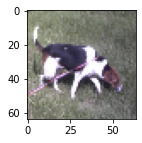

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(x_train[np.random.randint(0, x_train.shape[0])]) # выведем случайное изображение

In [ ]:
x_train = x_train.astype('float32')/255.  # Масштабируем к 0 - 1.0
y_train = y_train.astype('float32')      # y => float32

In [ ]:
x_test = x_train[7000:7200]
y_test = y_train[7000:7200]
x_train = x_train[:7000]
y_train = y_train[:7000]

print(x_train.shape,x_test.shape, y_train.shape,y_test.shape,  )

(7000, 64, 64, 3) (200, 64, 64, 3) (7000, 2) (200, 2)


In [ ]:
batch_size = 50 # размер батча
latent_dim = 256 # размер скрытого слоя/пространства
num_classes = 2
start_lr = 0.001 # шаг обучения
from keras.layers import Convolution2D
def create_cvae(): # объявляем функцию создания вариационного автокодировщика c условием
    models = {} # задаем словарь моделей
    # Энкодер
    input_img = Input(shape=(64, 64, 3)) # размерности строк, столбцов, фильтров одной картинки

    x = Convolution2D(32, (3,3), strides=(2, 2), padding='same', activation='relu')(input_img)
    x = BatchNormalization()(x)
    #x = MaxPooling2D()(x)
    x = Convolution2D(64, (3,3), strides=(2, 2), padding='same',activation='relu')(x)
    x = Conv2D(64, (3,3), strides=(2, 2), padding='same',activation='relu')(x)
    x = BatchNormalization()(x)
    flatten_img = Flatten()(x) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    input_lbl = Input(shape=(num_classes,), dtype='float32') # второй вход в энкодер с учетом лейблов и по количеству классов

    x = concatenate([flatten_img, input_lbl]) # конкатенируем входы сглаженной входной картинки и input_lbl
    
    # Предсказываем параметры распределений   
    # Вместо того чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 8
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 8

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        # керасовским методом делаем нормальное распределение(500 8мерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (8,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) 

    models["encoder"]  = Model([input_img, input_lbl], l, 'Encoder') # модель энкодера от входов до лямбда слоя
    models["z_meaner"] = Model([input_img, input_lbl], z_mean, 'Enc_z_mean') # отдельная модель с путем от входов до z_mean
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var, 'Enc_z_log_var') # отдельная модель с путем от входов до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем первую входную размерность (8,)
    input_lbl_d = Input(shape=(num_classes,), dtype='float32') # задаем вторую входную размерность по номеру классов
    x = concatenate([z, input_lbl_d]) # конкатенируем входы

    x = Dense(8*8*64*3, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    x = Reshape((8, 8, 64*3))(x) # меняем форму, приводим к нужным нам размерам

    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='elu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='elu')(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='elu')(x) # слой разжимает данные(с 56*32 на 112*80)
    x = BatchNormalization()(x)
    # Финальный слой двумерной свертки, выдающий итоговое изображение
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    models["decoder"] = Model([z, input_lbl_d], decoded, name='Decoder') # собираем модель декодера
    
    # Cобираем вариационный автокодировщик с условием(3 инпута на входе, затем первые два проходят через энкодер,
    # складываются с input_lbl_d и всё это проходит через декодер на выходе)
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d], 
                              models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), 
                              name="CVAE")
    # Та же операция, но вместо энкодера модель z_meaner
    models["style_t"] = Model( [input_img, input_lbl, input_lbl_d] , 
                               models["decoder"] ( [models["z_meaner"]([input_img, input_lbl]), input_lbl_d] ) , 
                               name="style_transfer")
    
    
    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 64*64*3)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 64*64*3)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 64*64*3*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/64/64/3 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_cvae() # получаем модели и свою функцию потерь
cvae = models["cvae"] # задаем модель вариационного автокодировщика с условием

cvae.compile(optimizer = Adam(start_lr), loss=vae_loss) # компилируем модель 

# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch %2 == 0 :
        #clear_output() # Не захламляем output
        dec = cvae.predict([x_test[:batch_size], y_test[:batch_size], y_test[:batch_size]], batch_size=batch_size)
        plt.figure(figsize=(12,2)) # oтрисовкa картинокк
        for i in range(5) :
            plt.subplot(1, 5, i+1)
            plt.imshow(dec[i*batch_size//7]) # выведем изображение
        plt.show()

pltg = LambdaCallback(on_epoch_end=on_epoch_end)

# Запуск обучения 
#cvae.fit([x_train, y_train, y_train], x_train, epochs=20, batch_size=batch_size, validation_data=([x_test, y_test, y_test], x_test),
              # callbacks=[pltg], verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

Train on 7000 samples, validate on 200 samples
Epoch 1/50
6950/7000 [============================>.] - ETA: 1s - loss: 0.3241

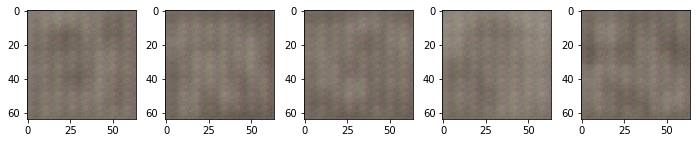

7000/7000 [==============================] - 215s - loss: 0.3240 - val_loss: 0.3344
Epoch 2/50
7000/7000 [==============================] - 208s - loss: 0.3040 - val_loss: 0.3187
Epoch 3/50
6950/7000 [============================>.] - ETA: 1s - loss: 0.3015

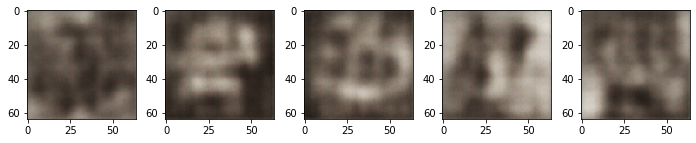

7000/7000 [==============================] - 207s - loss: 0.3015 - val_loss: 0.3038
Epoch 4/50
7000/7000 [==============================] - 211s - loss: 0.2998 - val_loss: 0.2993
Epoch 5/50
6950/7000 [============================>.] - ETA: 1s - loss: 0.2980

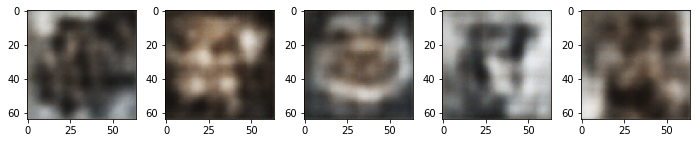

7000/7000 [==============================] - 209s - loss: 0.2980 - val_loss: 0.2970
Epoch 6/50
7000/7000 [==============================] - 209s - loss: 0.2966 - val_loss: 0.2965
Epoch 7/50
6950/7000 [============================>.] - ETA: 1s - loss: 0.2956

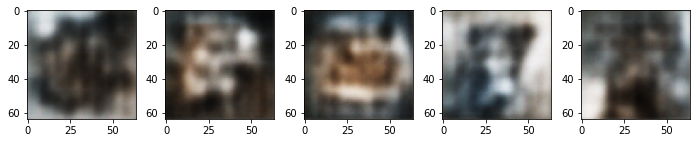

7000/7000 [==============================] - 209s - loss: 0.2955 - val_loss: 0.2958
Epoch 8/50
7000/7000 [==============================] - 207s - loss: 0.2950 - val_loss: 0.2955
Epoch 9/50
6950/7000 [============================>.] - ETA: 1s - loss: 0.2945

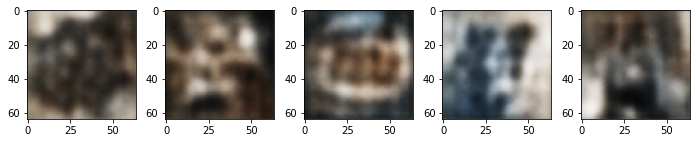

7000/7000 [==============================] - 205s - loss: 0.2946 - val_loss: 0.2944
Epoch 10/50
7000/7000 [==============================] - 205s - loss: 0.2942 - val_loss: 0.2938
Epoch 11/50
6950/7000 [============================>.] - ETA: 1s - loss: 0.2940

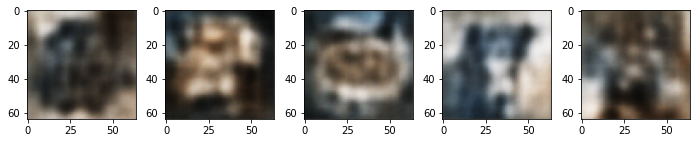

7000/7000 [==============================] - 207s - loss: 0.2940 - val_loss: 0.2938
Epoch 12/50
7000/7000 [==============================] - 205s - loss: 0.2938 - val_loss: 0.2933
Epoch 13/50
6950/7000 [============================>.] - ETA: 1s - loss: 0.2937

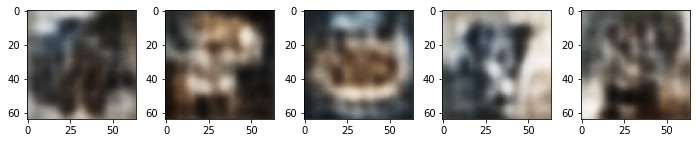

7000/7000 [==============================] - 206s - loss: 0.2937 - val_loss: 0.2935
Epoch 14/50
7000/7000 [==============================] - 205s - loss: 0.2936 - val_loss: 0.2942
Epoch 15/50
6950/7000 [============================>.] - ETA: 1s - loss: 0.2934

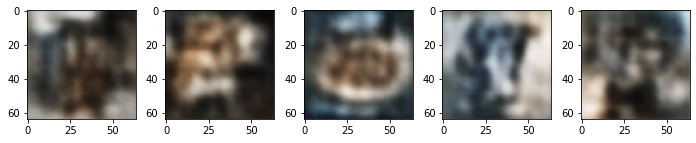

7000/7000 [==============================] - 206s - loss: 0.2934 - val_loss: 0.2931
Epoch 16/50
7000/7000 [==============================] - 205s - loss: 0.2932 - val_loss: 0.2929
Epoch 17/50
6950/7000 [============================>.] - ETA: 1s - loss: 0.2932

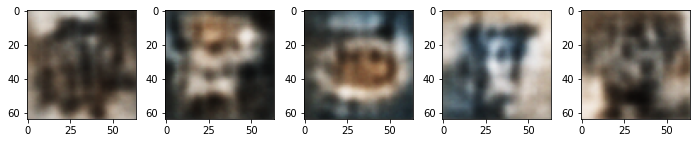

7000/7000 [==============================] - 205s - loss: 0.2932 - val_loss: 0.2928
Epoch 18/50
7000/7000 [==============================] - 203s - loss: 0.2930 - val_loss: 0.2929
Epoch 19/50
6950/7000 [============================>.] - ETA: 1s - loss: 0.2930

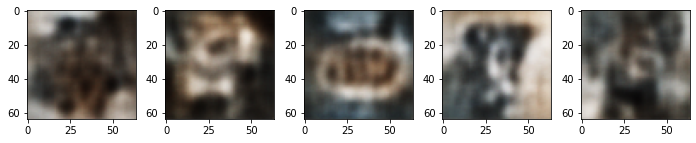

7000/7000 [==============================] - 207s - loss: 0.2930 - val_loss: 0.2929
Epoch 20/50
7000/7000 [==============================] - 208s - loss: 0.2929 - val_loss: 0.2930
Epoch 21/50
6950/7000 [============================>.] - ETA: 1s - loss: 0.2930

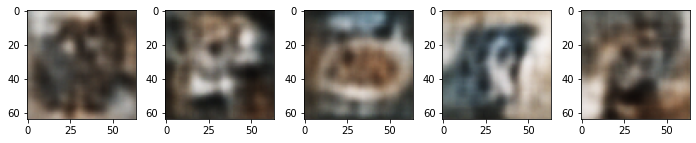

7000/7000 [==============================] - 208s - loss: 0.2930 - val_loss: 0.2930
Epoch 22/50
7000/7000 [==============================] - 210s - loss: 0.2928 - val_loss: 0.2926
Epoch 23/50
6950/7000 [============================>.] - ETA: 1s - loss: 0.2927

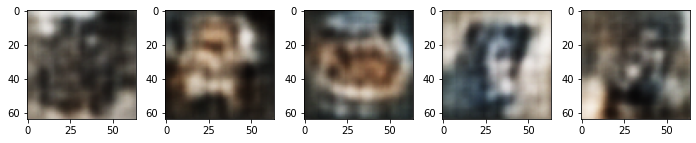

7000/7000 [==============================] - 213s - loss: 0.2927 - val_loss: 0.2926
Epoch 24/50
7000/7000 [==============================] - 210s - loss: 0.2926 - val_loss: 0.2924
Epoch 25/50
6950/7000 [============================>.] - ETA: 1s - loss: 0.2926

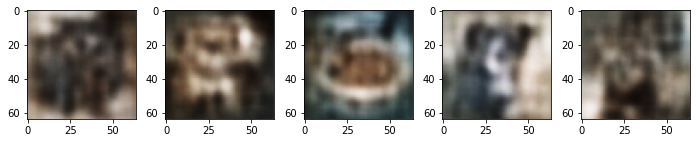

7000/7000 [==============================] - 211s - loss: 0.2926 - val_loss: 0.2924
Epoch 26/50
7000/7000 [==============================] - 211s - loss: 0.2925 - val_loss: 0.2923
Epoch 27/50
3900/7000 [===============>..............] - ETA: 92s - loss: 0.2927

KeyboardInterrupt: ignored

In [ ]:
cvae.compile(optimizer = Adam(start_lr/2), loss=vae_loss) # компилируем модель

callbacks = [ModelCheckpoint(filepath='/content/drive/MyDrive/cvae.h5', 
              verbose=0, save_best_only=True, save_weights_only=False), 
                            LambdaCallback(on_epoch_end=on_epoch_end)]

# Запуск обучения 
cvae.fit([x_train, y_train, y_train], x_train, epochs=50, batch_size=batch_size,
         validation_data=([x_test, y_test, y_test], x_test), callbacks=callbacks, verbose=1) 

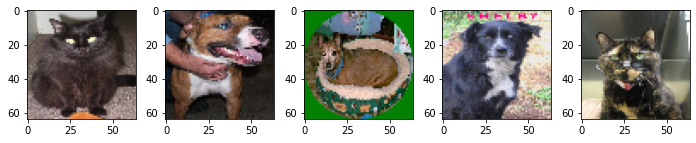

In [ ]:
# Исходные изображения
plt.figure(figsize=(12,2)) # oтрисовкa картинок
for i in range(5) :
      plt.subplot(1, 5, i+1)
      plt.imshow(x_test[i*batch_size//7]) # выведем изображение
plt.show()

In [ ]:
cvae.load_weights('/content/drive/MyDrive/cvae.h5')